 
# Quora Insincere Questions Classification   
### 박 준 영  ● 박 서 정 ●  권 효 준 ● 안 민 재    


### Outline 

1. Quora 및 문제 설명
2. 최종 모델
3. 데이터 전처리 과정
4. 모델 튜닝 

## Quora? 
- a question-and-answer website
- a platform to ask questions and connect with people who contribute unique insights and quality answers

![Image of Quora](./screenshot.png)

![Image of Quora](./screenshot1.png)

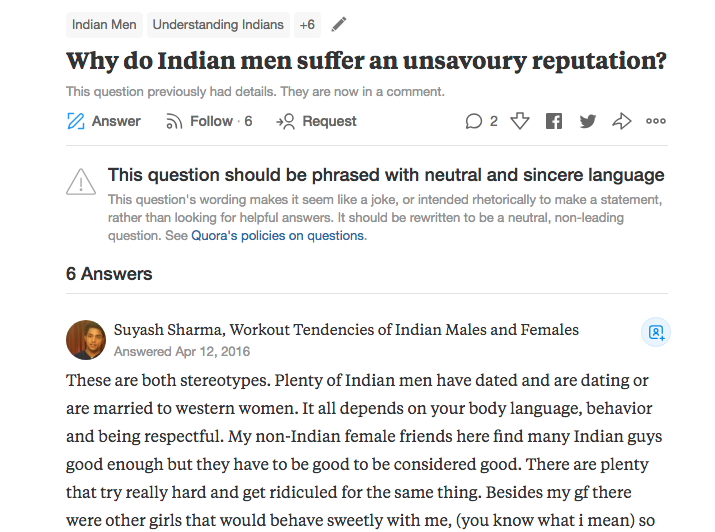

## `target`=1 , 진정성 없는 질문, TOXIC? 
- Has a non-neutral tone
- Is disparaging or inflammatory
- Isn't grounded in reality
- Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

In [1]:
import gensim

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [179]:
import collections
import string
import unicodedata
from pycontractions import Contractions

import nltk
import spacy

from nltk.tokenize import regexp_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from multiprocessing import Pool

import time
from nltk.corpus import stopwords

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import *

%matplotlib inline

pd.set_option('max_rows', 200, 'max_columns', 100)
pd.set_option('max_colwidth', 100)

from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

In [180]:
#multiprocessing을 위한 세팅
num_partitions = 10 #number of partitions to split dataframe
num_cores = 4 #number of cores on your machine

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [181]:
df = pd.read_csv('./train.csv')

# 1. 데이터 소개

## 1-1. 데이터 셋의 구성
- `1306122` 개의 Data 
---
| qid |  question_text   |  target |
|:-----:|:------------------:|:---------:|
|   질문 고유 id | 질문 (Text Data) | `0` : 진정성 있는 질문|
|           ...|              ...| `1` : 진정성 없는 질문 (선별해야하는 대상)|


In [182]:
df[df['target']==0].head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [183]:
df[df['target']==1].head()

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dictatorship in the world?,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents? Dark skin babies or light skin babies?,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory sentencing for criminals why don't they vote Repub...,1
114,00052793eaa287aff1e1,"I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and ...",1
115,000537213b01fd77b58a,Which races have the smallest penis?,1


In [184]:
df.shape

(1306122, 3)

### 1-2. 비대칭 데이터
- 진정성 없는 질문(Toxic = Target 1)이   
    전체 데이터 중 **6%** 를 차지 

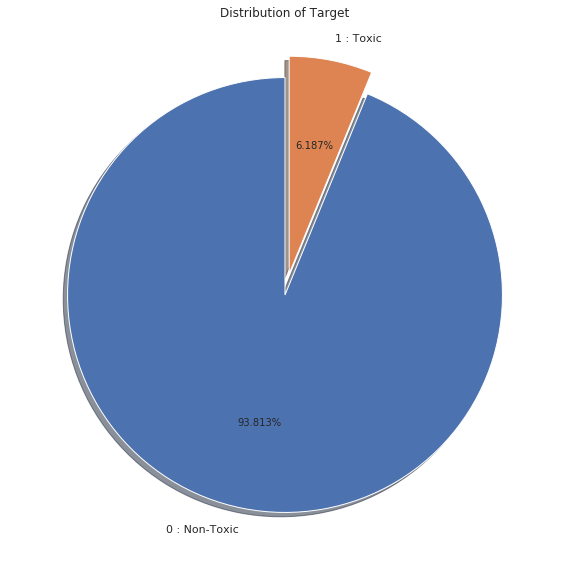

In [185]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_title("Distribution of Target")
explode = (0, 0.1)
labels = ['0 : Non-Toxic','1 : Toxic']
ax.pie(list(dict(collections.Counter(list(df.target))).values()), explode=explode, labels=labels, autopct='%1.3f%%',shadow=True, startangle=90)
plt.show()

## EVALUATION
- F1 SCORE
$$
F_1 = 2 \cdot \text{precision} \cdot \text{recall} \, / \, (\text{precision} + \text{recall})
$$

## 최종 모델 성능

- CountVectorizer : `ngram_range` = (1,2)
- Logistic Regression: `class_weight` = {0: 0.1505, 1 : 0.8494}

![perfomance](./performance.png)

# 위 결과를 얻기 까지...

## TEXT NORMALIZATION
- 데이터들을 하나씩 살펴보면서,     
    발견된 `특이한` 데이터들을 처리

## Preprocessing 1
- unicodedata.normalize("NFKD")
- `\xa0` : 유니코드의 공백에 해당
- `\u200b` : 유니코드 의 제로너비공백에 해당 

In [186]:
df['question_text'].iloc[1025305]

"Are\xa0Jehovah's Witnesses\xa0evil?"

In [187]:
df['question_text'] = df['question_text'].progress_apply(lambda data: unicodedata.normalize("NFKD", data))

100%|██████████| 1306122/1306122 [00:01<00:00, 761004.60it/s]


In [188]:
df['question_text'].iloc[61393]

'Where\u200b are\u200b you\u200b from\u200b?'

In [189]:
df['question_text'] = df['question_text'].apply(lambda x: x.replace('\u200b', ' '))

In [190]:
df['question_text'].iloc[1025305]

"Are Jehovah's Witnesses evil?"

In [191]:
df['question_text'].iloc[61393]

'Where  are  you  from ?'

## Preprocessing 2
- 특이한 따옴표, 쌍따옴표 대체

In [192]:
df['question_text'].iloc[1239630]

'What’s raket speed?'

In [193]:
df['question_text'].iloc[30780]

'Who said "“Idhar dharna, udhar dharna. Tujhse khansi to theek hui nahin, Delhi kya theek karega. Main koi jhooth bolea? "'

In [194]:
df['question_text'] = df['question_text'].apply(lambda x: x.replace('’', "'"))
df['question_text'] = df['question_text'].apply(lambda x: x.replace('“', '"'))

In [195]:
df['question_text'].iloc[1239630]

"What's raket speed?"

In [196]:
df['question_text'].iloc[30780]

'Who said ""Idhar dharna, udhar dharna. Tujhse khansi to theek hui nahin, Delhi kya theek karega. Main koi jhooth bolea? "'

## Preprocessing 3
####  `GoogleNews-vectors-negative300` word2vec & `pycontraction` package

- `Isn't` → `Is not` 
- `I'd` → `I would`
- `I'd` → `I had`
- `We're` → `We are`

In [197]:
df['question_text'].iloc[1306103]

"Isn't Trump right after all? Why should the USA be benevolent towards it's neighbor Mexico, and not put America first, when Russia is invading Ukraine? Even India imposed a blockade over Nepal after an earthquake?"

In [198]:
cont = Contractions('./embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin')

In [199]:
list(cont.expand_texts(["Isn't Trump right after all? Why should the USA be benevolent towards it's neighbor Mexico, and not put America first, when Russia is invading Ukraine? Even India imposed a blockade over Nepal after an earthquake?"], precise=True)).pop()

'is not Trump right after all? Why should the USA be benevolent towards it is neighbor Mexico, and not put America first, when Russia is invading Ukraine? Even India imposed a blockade over Nepal after an earthquake?'

### case 1 : 's
### case 2 : 외국어

In [200]:
list(cont.expand_texts(["Are Jehovah's Witnesses evil?"], precise=True)).pop()

"Are Jehovah's Witnesses evil?"

In [201]:
list(cont.expand_texts(["Si je parle diversement c'est que je me regarde diversement.What does this mean?"], precise=True)).pop()

"Si je parle diversement c'est que je me regarde diversement.What does this mean?"

In [202]:
def multi_expand_texts(data):
    data['question_text'] = data['question_text'].progress_apply(lambda text: list(cont.expand_texts([text], precise=True)).pop())
    return data

In [203]:
df = parallelize_dataframe(df, multi_expand_texts)

100%|██████████| 130612/130612 [02:10<00:00, 997.31it/s] 


## Preprocessing 4
### Tokenize & Lemmatize

#### `Spacy Tokenizer + Lemmatizer`  + `lower case` 처리

## Spacy 와 NLTK Tokenizer/ Lemmatizer 의 비교
- `SPACY` 를 선택한 이유

    1. 동사의 원형와의 차이
    2. Punctuation 의 차이

In [204]:
import nltk
nltk_result = []
tokenizer = nltk.tokenize.TreebankWordTokenizer()
stemmer = nltk.stem.WordNetLemmatizer()
for token in tokenizer.tokenize(df.question_text.iloc[8737]):
    if token not in string.punctuation:
        nltk_result.append(stemmer.lemmatize(token.lower()))

import spacy
spacy_result = []
nlp = spacy.load("en")
doc = nlp(df.question_text.iloc[8737])
for token in doc: 
    if not token.is_punct | token.is_space:
        spacy_result.append(token.lemma_)

result = {}
result["NLTK"] = nltk_result
result["SPACY"] = spacy_result
print("실제 데이터 : ", df.question_text.iloc[8737])
pd.DataFrame(result, columns=("NLTK", "SPACY"))


실제 데이터 :  What is the difference between the words 'electric', 'electronic', 'electrical'?


,NLTK,SPACY
0,what,what
1,is,be
2,the,the
3,difference,difference
4,between,between
5,the,the
6,word,word
7,'electric,electric
8,'electronic,electronic
9,'electrical,electrical


In [205]:
nlp = spacy.load('en', disable=["tagger", "parser", "ner"], entity=False)
def spacy_lemmatizer(doc):
    return [token.lemma_.lower() for token in nlp(doc) if not token.is_punct | token.is_space]

In [206]:
def multi_spacy(data):
    data['spacy_lemmatized'] = data['question_text'].progress_apply(lambda text: spacy_lemmatizer(text))
    return data

In [207]:
df = parallelize_dataframe(df, multi_spacy)

100%|██████████| 130612/130612 [00:43<00:00, 3015.36it/s]


In [208]:
df.head()

,qid,question_text,target,spacy_lemmatized
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0,"[how, do, quebec, nationalist, see, their, province, a, a, nation, in, the, 1960s]"
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0,"[do, you, have, a, adopt, dog, how, would, you, encourage, people, to, adopt, and, not, shop]"
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0,"[why, doe, velocity, affect, time, does, velocity, affect, space, geometry]"
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0,"[how, do, otto, von, guericke, use, the, magdeburg, hemisphere]"
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0,"[can, i, convert, montra, helicon, d, to, a, mountain, bike, by, just, change, the, tyre]"


## Train & Test Split
### Stratify Split

In [209]:
df_target = df.iloc[:,2]
df.drop(columns= 'target', inplace=True)
df['target'] = df_target
train_data, test_data, train_target, test_target = train_test_split(df.iloc[:,:-1],df.target, stratify=df['target'], test_size=0.15, random_state=0)

## Baseline Model
1. CountVectorizer : `ngram_range = (1,1)`
2. RandomunderSampler
3. Multinomial Naive Baysian

In [210]:
def do_nothing(tokens):
    return tokens

base_model = make_pipeline(
    CountVectorizer(tokenizer=do_nothing,
                             preprocessor=None,
                             lowercase=False),
    RandomUnderSampler(),
    MultinomialNB(),
)

In [211]:
base_model.fit(train_data.spacy_lemmatized, train_target)
print(classification_report(test_target, base_model.predict(test_data.spacy_lemmatized)))

              precision    recall  f1-score   support

           0       0.99      0.80      0.89    183797
           1       0.23      0.93      0.37     12122

   micro avg       0.81      0.81      0.81    195919
   macro avg       0.61      0.86      0.63    195919
weighted avg       0.95      0.81      0.85    195919



In [213]:
print(confusion_matrix(test_target, base_model.predict(test_data.spacy_lemmatized)))

[[146722  37075]
 [   883  11239]]


## Improvement : LOGISTIC REGRESSION MODEL
1. CountVectorizer : `ngram_range = (1,2)`
2. LogisticRegression
    - 1st ATTEMPT :  `class_weight` - Balanced (First-TRIAL)

    - 2nd ATTEMPT : `class_weight` - GRID SEARCH 로 찾기

In [175]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]

In [81]:
classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
                 ('selector', TextSelector('spacy_lemmatized')),
            ('vectorizer', CountVectorizer(tokenizer=do_nothing, \
                                           ngram_range=(1,2), lowercase=False))
        ])),
    ])),
    ('clf', LogisticRegression(class_weight='balanced')),
    ])

model = classifier.fit(train_data, train_target)
y_hat = model.predict(test_data)
print(classification_report(y_hat, test_target))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    180012
           1       0.72      0.55      0.62     15907

   micro avg       0.95      0.95      0.95    195919
   macro avg       0.84      0.76      0.80    195919
weighted avg       0.94      0.95      0.94    195919



## Grid SEARCH for `class_weight`
- `0`:`1`  = `x`: `1-x`
- `x` - [0.05 , 0.95] 범위에서 탐색
- 결과 : `x`가 **0.145** 근처에서, f1_mean_test_score 가 최대

Best parameters : {'clf__class_weight': {0: 0.14473684210526316, 1: 0.8552631578947368}}


/Users/emjayahn/.pyenv/versions/3.7.0/envs/dss/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['d2coding'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/emjayahn/.pyenv/versions/3.7.0/envs/dss/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['d2coding'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


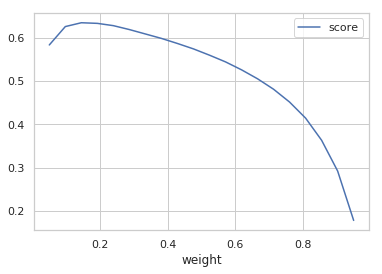

In [86]:
from sklearn.model_selection import GridSearchCV

weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=classifier,
    param_grid={
        'clf__class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=5,
    n_jobs=4
)
with parallel_backend('threading'):
    grid_result = gsc.fit(train_data, train_target)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

### `x` optimal 값 찾기
- 위에서 얻은 결과로, 범위를 세분화하여 탐색
- [0.14, 0.19] 범위로 재탐색
- 결과 : `x`가 0.1505 일 때 최대
- 따라서, `class_weight` parameter 를     
    class 0 : class 1 = 0.1505 : 0.8494 로 주었습니다.

Best parameters : {'clf__class_weight': {0: 0.1505263157894737, 1: 0.8494736842105263}}


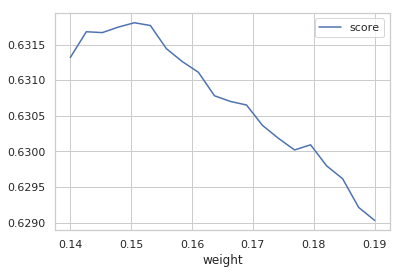

In [87]:
weights = np.linspace(0.14, 0.19, 20)

gsc = GridSearchCV(
    estimator=classifier,
    param_grid={
        'clf__class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=3,
    n_jobs=4
)
with parallel_backend('threading'):
    grid_result = gsc.fit(train_data, train_target)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

## FINAL MODEL
- CountVectorizer = `ngram_range` = (1,2)
- LogisicRegression(class_weight={0: 0.1505, 1: 0.8494})

In [214]:
classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
                 ('selector', TextSelector('spacy_lemmatized')),
            ('vectorizer', CountVectorizer(tokenizer=do_nothing, ngram_range=(1,2), lowercase=False))
        ])),
    ])),
    ('clf', LogisticRegression(class_weight={0: 0.1505, 1: 0.8494})),
    ])

In [215]:
model = classifier.fit(train_data, train_target)
y_pred = model.predict(test_data)
print(classification_report(y_pred, test_target))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97    180974
           1       0.72      0.58      0.64     14945

   micro avg       0.95      0.95      0.95    195919
   macro avg       0.84      0.78      0.81    195919
weighted avg       0.95      0.95      0.95    195919



In [218]:
print("- Confusion Matrix")
print(confusion_matrix(y_pred, test_target))

- Confusion Matrix
[[177524   3450]
 [  6273   8672]]


## Cross Validation 결과
- Cross Validation 결과를 볼 때, 편차가 크지 않으므로, 안정적인 모델입니다.

In [219]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
final_score = 0

cv = StratifiedKFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df, df['target'])):
    df_train, df_train_y = df.iloc[idx_train], df['target'].iloc[idx_train]
    df_test, df_test_y = df.iloc[idx_test], df['target'].iloc[idx_test]
    classifier.fit(df_train, df_train_y)
    y = classifier.predict(df_test)
    temp_score = f1_score(y, df_test_y)
    print("{} Validation F1 SCORE : {}".format(i, temp_score))
    final_score += temp_score
    
print('final score: {}'.format(final_score/5))

0 Validation F1 SCORE : 0.6368871247274556
1 Validation F1 SCORE : 0.6355920411854737
2 Validation F1 SCORE : 0.6394648089788246
3 Validation F1 SCORE : 0.6392519215294542
4 Validation F1 SCORE : 0.6392643474407267
final score: 0.638092048772387


# 감사합니다 :)